In [1]:
## This file contains the basic function of read data and clean filter.
## Author: Xiang Li

###Sample
#### Imput Package
from pandas import pandas as pd
import numpy
import os
from scipy import stats
from optparse import OptionParser
from matplotlib import pyplot as plt
import HTSeq

plt.switch_backend('agg')

# display plots in this notebook
%matplotlib inline

In [68]:
def Get_GeneBody_Profile(INPUT_read_file, INPUT_gtf_file, Feature_Type_Used, INPUT_gene_list, genic_partition, fragment_size):
    ## Read Reads_File, and distribute them into GenomicArray.
    num_reads = 0
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="d")
    bedfile = HTSeq.BED_Reader(INPUT_read_file)
    for alngt in bedfile:
        ga[alngt.iv] += 1.0/alngt.iv.length
        num_reads+=1
##########################################################################################
    ## Read gtf_file
    gtffile = HTSeq.GFF_Reader(INPUT_gtf_file)
##########################################################################################    
    ## Read Gene_list_file
    gene_list = pd.read_csv(INPUT_gene_list, header=None, sep='\s+', usecols=[3])[3].str.strip()
    gene_list_unique=gene_list.unique()
##########################################################################################
    ### To calculate the number of transcripts that for profile plot.
    ### And also store position in a set.
    site_iv_set = set()
    
    gff_feature_type_for_profile = Feature_Type_Used

    for feature in gtffile:
        if feature.type == Feature_Type_Used and feature.attr["gene_id"] in gene_list_unique:
            site_iv_set.add(feature.iv)
    
    profile = numpy.zeros(genic_partition)
    Num_Skip = 0
    for site_iv in site_iv_set:
        partition_size =site_iv.length / (1.0*genic_partition) ## Prevent int division
        if(partition_size < 1):
            Num_Skip +=1 
            continue
##########################################################################################
        index = 0
        for site_pos in site_iv.xrange_d(partition_size):
            count_in_window = 0
            if site_pos.strand == "+":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos, site_pos.pos + partition_size)
            elif site_pos.strand == "-":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos - partition_size + 1,
                                                           site_pos.pos + 1)

            for step_iv, step_count in ga[site_pos_window_iv].steps():
                count_in_window += step_count * step_iv.length
            profile[index] += count_in_window / (1.0*partition_size)
            index += 1
            if index >= genic_partition:
                break
    
    print "...................................................."
    print "Profile on: TSS_GeneBody_TES "
    print "Number of transcripts: %i" % len(site_iv_set)
    print "Number of reads: %i" % num_reads 
    print "...................................................."
    print ("Total Number of Skipped gene_list: "+str(Num_Skip))
    print ("Because their length are less than your choose genic_partition")
        
    return  (profile*(10**9)/(num_reads*(len(site_iv_set)-Num_Skip)))

In [71]:
def Distribute_By_Pileup(input_tag_file):
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="d")
    bedfile = HTSeq.BED_Reader(input_tag_file) ## input tags
    num_reads=0
    for alngt in bedfile:  # Total contribution of a single tag is ONE 
        ga[alngt.iv] += 1.0/alngt.iv.length
        num_reads+=1
    print "Number of Tags Being Distributed : %i" % num_reads
    return ga,num_reads

def Distribute_By_MiddlePoint(input_tag_file):
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="d")
    bedfile = HTSeq.BED_Reader(input_tag_file) ## input tags
    num_reads=0
    for alt in bedfile:
        alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, (alt.iv.start + alt.iv.end) / 2)
        ga[alt_pos]+=1
        num_reads+=1
    print "Number of Tags Being Distributed : %i" % num_reads
    return ga,num_reads

def Site_Position_Summit(input_site_file):
    ##########################################################################################    
##########################################################################################
    ### To calculate the number of transcripts that for profile plot.
    ### And also store position in a set.

    site_file = HTSeq.BED_Reader(input_site_file)
    site_pos_set = set()
    for site in site_file:
        site_pos_set.add(HTSeq.GenomicPosition(site.iv.chrom, (site.iv.start_d + site.iv.end_d)/2,site.iv.strand))
    print "Number of Profiles Being Averaged : %i" % len(site_pos_set)
    return site_pos_set

def Site_Position_Boundary(input_site_file, boundary_type):
    site_file = HTSeq.BED_Reader(input_site_file)
    site_pos_set = set()
    if (boundary_type=='TSS'):
        for site in site_file:
            site_pos_set.add(HTSeq.GenomicPosition(site.iv.chrom, site.iv.start_d, site.iv.strand))
    elif(boundary_type=='TES'):
        for site in site_file:
            site_pos_set.add(HTSeq.GenomicPosition(site.iv.chrom, site.iv.end_d, site.iv.strand))
    else:
        for site in site_file:
            site_pos_set.add(HTSeq.GenomicPosition(site.iv.chrom, site.iv.start, site.iv.strand))
            site_pos_set.add(HTSeq.GenomicPosition(site.iv.chrom, site.iv.end, site.iv.strand))
    print "Number of Profiles Being Averaged : %i" % len(site_pos_set)
    return site_pos_set

def Get_Profile_At_Point(ga, site_pos_set, resolution, window_size, upstreamExtension, downstreamExtension):
    ## ga is tags distribution, site_pos_set the sites for profile
    upstream_num_points = upstreamExtension / resolution
    downstream_num_points = downstreamExtension / resolution
    total_num_points = upstream_num_points + downstream_num_points + 1
##########################################################################################  
    profile = numpy.zeros(total_num_points)
    for tss_pos in site_pos_set:
            index = 0
            while index < total_num_points:
                count_in_window = 0
                if tss_pos.strand == "+":
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2, index_pos + window_size / 2 )
                elif tss_pos.strand == "-":
                    index_pos = tss_pos.pos - (index - upstream_num_points) * resolution + 1
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 , index_pos + window_size / 2 )
                else:
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    if (index_pos - window_size / 2) < 0:
                        index += 1
                        continue
                    else:
                        tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 , index_pos + window_size / 2 +1)
                for step_iv, step_count in ga[tss_pos_window_iv].steps():
                    count_in_window += step_count * step_iv.length
                ###gives average read count for position
                profile[index] += count_in_window / (1.0*window_size)
                index += 1
    return profile

def Site_Position_Region(input_site_file, num_region_partition):
    site_file = HTSeq.BED_Reader(input_site_file)
    site_pos_set = set()
    Num_Skip = 0
    for site in site_file:
        if (site.iv.length < num_region_partition):
            Num_Skip+=1
            continue
        else:
            site_pos_set.add(site.iv)
    print "Number of Profiles Being Dropped (Length Less than Number of Partitions) : %i" % Num_Skip
    print "Number of Profiles Being Averaged : %i" % len(site_pos_set)
    return site_pos_set

def Get_Profile_In_Region(ga, site_pos_set, num_region_partition):
    # These methods yield iterators of :class:GenomicPosition objects from start to end (or, for xrange_d from start_d to end_d).
    profile = numpy.zeros(num_region_partition)  ### | | | | | |   5 partitions but only four sites for profile.

    for site_iv in site_pos_set:
        partition_size = site_iv.length / (1.0*genic_partition) ## Prevent int division
        for index in range(num_region_partition):
            if site_iv.strand=="+":
                site_pos_window_iv = HTSeq.GenomicInterval(site_iv.chrom, site_iv.start_d+ (index)*partition_size, site_iv.start_d + (index+1)*partition_size+1) 
            elif site_iv.strand=="-":
                site_pos_window_iv = HTSeq.GenomicInterval(site_iv.chrom, site_iv.start_d- (index)*partition_size, site_iv.start_d - (index-1)*partition_size+1)
            elif site_iv.strand==".":
                site_pos_window_iv = HTSeq.GenomicInterval(site_iv.chrom, site_iv.start_d+ (index)*partition_size, site_iv.start_d + (index+1)*partition_size+1) 
            count_in_window = 0
            for step_iv, step_count in ga[site_pos_window_iv].steps():
                count_in_window += step_iv.length * step_count
            profile[index] += count_in_window / (1.0*partition_size)
    
    return profile

In [31]:
def Get_Summit_Profile(input_tag_file, input_site_file, resolution, window_size, upstreamExtension, downstreamExtension):
    ## Pileup Or
    ga, num_reads = Distribute_By_Pileup(input_tag_file)
    ## Middle Point
    #ga, num_reads = Distribute_By_MiddlePoint(input_tag_file)
##########################################################################################
    ## Read Site file
    site_pos_set = Site_Position_Summit(input_site_file)
##########################################################################################
    profile = Get_Profile_At_Point(ga, site_pos_set, resolution, window_size, upstreamExtension, downstreamExtension)
    print "Profile on Sites Summit "
    print "...................................................."
    return  (profile*(10**9)/(num_reads*len(site_pos_set)))

def Get_Boundary_Profile(boundary_type, input_tag_file, input_site_file, resolution, window_size, upstreamExtension,downstreamExtension):
    ## Pileup Or
    ga, num_reads = Distribute_By_Pileup(input_tag_file)
    ## Middle Point
    #ga, num_reads = Distribute_By_MiddlePoint(input_tag_file)
##########################################################################################
    ## Read Site file
    site_pos_set = Site_Position_Boundary(input_site_file, boundary_type)
##########################################################################################
    profile = Get_Profile_At_Point(ga, site_pos_set, resolution, window_size, upstreamExtension, downstreamExtension)
    print "Profile on Site Boundary "+ boundary_type
    print "...................................................."
    return  (profile*(10**9)/(num_reads*len(site_pos_set)))

def Get_Bed_Region_Profile(input_tag_file, input_site_file, num_region_partition):
    ## Pileup Or
    ga, num_reads = Distribute_By_Pileup(input_tag_file)
    ## Middle Point
    #ga, num_reads = Distribute_By_MiddlePoint(input_tag_file)
##########################################################################################
    ## Read Site file
    site_pos_set = Site_Position_Region(input_site_file, num_region_partition)
##########################################################################################
    profile = Get_Profile_In_Region(ga, site_pos_set, num_region_partition)
    print "Profile on Site Region"
    print "Number of Profiles Being Averaged : %i" % len(site_pos_set)
    print "...................................................."
    return (profile*(10**9)/(num_reads*len(site_pos_set)))

Number of Tags Being Distributed : 3050942
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 0
Number of Profiles Being Averaged : 1297
Profile on Site Region
Number of Profiles Being Averaged : 1297
....................................................
Number of Tags Being Distributed : 2670838
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 0
Number of Profiles Being Averaged : 1297
Profile on Site Region
Number of Profiles Being Averaged : 1297
....................................................


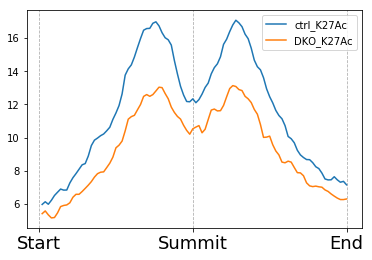

In [12]:
# pileup
INPUT_read_file = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/ctrl_CD8_K27Ac/ctrl_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed'

INPUT_read_file_2 ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/dKO_CD8_K27Ac/dKO_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed"


INPUT_gene_list="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/1297_Tcf1_Motif_+_Union_peak_ex1000.bed"

genic_partition = 100

norm_profile   = Get_Bed_Region_Profile(INPUT_read_file, INPUT_gene_list, genic_partition)
norm_profile2   = Get_Bed_Region_Profile(INPUT_read_file_2, INPUT_gene_list, genic_partition)
### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='ctrl_K27Ac')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile2[0:genic_partition], label='DKO_K27Ac')

ax.legend()
#ax.set_ylim(0,30)
x=[-genic_partition/2, 0, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','Middle Point','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

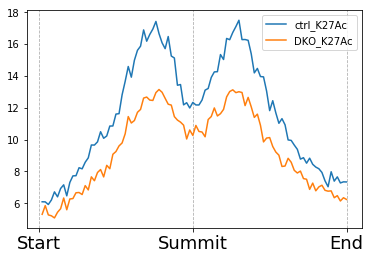

In [9]:
## middle point 
INPUT_read_file = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/ctrl_CD8_K27Ac/ctrl_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed'

INPUT_read_file_2 ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/dKO_CD8_K27Ac/dKO_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed"


INPUT_gene_list="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/1297_Tcf1_Motif_+_Union_peak_ex1000.bed"

genic_partition = 100

#norm_profile   = Get_Bed_Region_Profile(INPUT_read_file, INPUT_gene_list, genic_partition)
#norm_profile2   = Get_Bed_Region_Profile(INPUT_read_file_2, INPUT_gene_list, genic_partition)
### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='ctrl_K27Ac')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile2[0:genic_partition], label='DKO_K27Ac')

ax.legend()
#ax.set_ylim(0,30)
x=[-genic_partition/2, 0, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','Middle Point','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

Number of Tags Being Distributed : 3050942
Number of Profiles Being Averaged : 1297
Profile on Sites Summit 
....................................................
Number of Tags Being Distributed : 2670838
Number of Profiles Being Averaged : 1297
Profile on Sites Summit 
....................................................


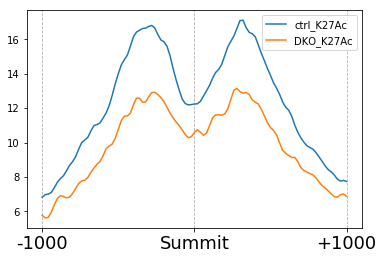

In [13]:
# pileup

INPUT_read_file = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/ctrl_CD8_K27Ac/ctrl_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed'

INPUT_read_file_2 ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/dKO_CD8_K27Ac/dKO_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed"


INPUT_gene_list="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/1297_Tcf1_Motif_+_Union_peak_For_HTseq.bed"

resolution = 20
upstreamExtension = 1000
num_profile_points= 2*upstreamExtension / resolution +1
window_size = 2*resolution
norm_profile   = Get_Summit_Profile(INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile2   = Get_Summit_Profile(INPUT_read_file_2, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)



### Plot     
fig, ax=plt.subplots(1,1)

ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile[0:num_profile_points], label='ctrl_K27Ac')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2[0:num_profile_points], label='DKO_K27Ac')


ax.legend()
#ax.set_ylim(0,30)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'Middle Point','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

Number of Tags Being Distributed : 3050942
Number of Profiles Being Averaged : 1297
Profile on Sites Summit 
....................................................
Number of Tags Being Distributed : 2670838
Number of Profiles Being Averaged : 1297
Profile on Sites Summit 
....................................................


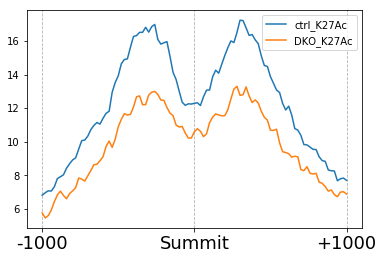

In [7]:
#middle point 

INPUT_read_file = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/ctrl_CD8_K27Ac/ctrl_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed'

INPUT_read_file_2 ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/dKO_CD8_K27Ac/dKO_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed"


INPUT_gene_list="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/1297_Tcf1_Motif_+_Union_peak_For_HTseq.bed"

resolution = 20
upstreamExtension = 1000
num_profile_points= 2*upstreamExtension / resolution +1
window_size = 2*resolution
norm_profile   = Get_Summit_Profile(INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile2   = Get_Summit_Profile(INPUT_read_file_2, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)



### Plot     
fig, ax=plt.subplots(1,1)

ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile[0:num_profile_points], label='ctrl_K27Ac')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2[0:num_profile_points], label='DKO_K27Ac')


ax.legend()
#ax.set_ylim(0,30)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'Middle Point','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')



Number of Tags Being Distributed : 100035
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 1224
Number of Profiles Being Averaged : 17144
Profile on Site Region
Number of Profiles Being Averaged : 17144
....................................................
Number of Tags Being Distributed : 112488
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 1224
Number of Profiles Being Averaged : 17144
Profile on Site Region
Number of Profiles Being Averaged : 17144
....................................................
Number of Tags Being Distributed : 18368
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 1224
Number of Profiles Being Averaged : 17144
Profile on Site Region
Number of Profiles Being Averaged : 17144
....................................................
....................................................
Profile on: TSS_3'UTR_TES 


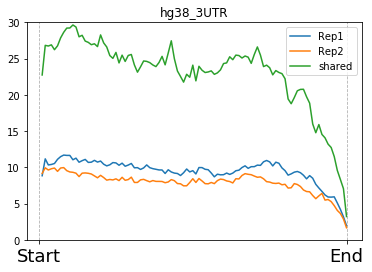

In [95]:
# Region Profile
PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'
INPUT_read_file = PATH_FOLDER+'/'+"Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"


PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'

Gene_Name='hg38_3UTR.bed'

INPUT_gene_list = PATH_FOLDER + Gene_Name

genic_partition = 100
norm_profile   = Get_Bed_Region_Profile(INPUT_read_file, INPUT_gene_list, genic_partition)
norm_profile_2 = Get_Bed_Region_Profile(INPUT_read_file2, INPUT_gene_list, genic_partition)
norm_profile_3 = Get_Bed_Region_Profile(INPUT_read_file3, INPUT_gene_list, genic_partition)

print "...................................................."
print "Profile on: TSS_3'UTR_TES "

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='Rep1')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='Rep2')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_3[0:genic_partition], label='shared')


ax.set_title(Gene_Name[:-4])
ax.legend()
ax.set_ylim(0,30)
x=[-genic_partition/2, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

Number of Tags Being Distributed : 100035
Number of Profiles Being Averaged : 18330
Profile on Site Boundary TES
....................................................
....................................................
Profile on: TSS_3'UTR_TES 


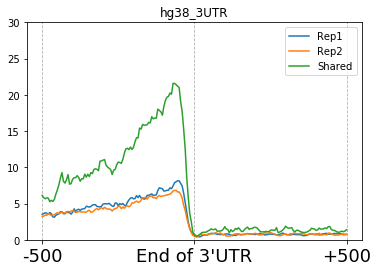

In [94]:
# Region Profile
PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'
INPUT_read_file = PATH_FOLDER+'/'+"Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"


PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'

Gene_Name='hg38_3UTR.bed'

INPUT_gene_list = PATH_FOLDER + Gene_Name
boundary_type='TES'

resolution = 5
upstreamExtension = 500
num_profile_points= 2*upstreamExtension / resolution +1
window_size = resolution

norm_profile_TES   = Get_Boundary_Profile(boundary_type, INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
norm_profile2_TES   = Get_Boundary_Profile(boundary_type, INPUT_read_file2, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
norm_profile3_TES   = Get_Boundary_Profile(boundary_type, INPUT_read_file3, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
print "...................................................."
print "Profile on: TSS_3'UTR_TES "

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_TES[0:num_profile_points], label='Rep1')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2_TES[0:num_profile_points], label='Rep2')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile3_TES[0:num_profile_points], label='Shared')


ax.set_title(Gene_Name[:-4])
ax.legend()
ax.set_ylim(0,30)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'End of 3\'UTR','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')
#ax.grid(True)

Number of Tags Being Distributed : 100035
Number of Profiles Being Averaged : 18335
Profile on Site Boundary TSS
....................................................
Number of Tags Being Distributed : 112488
Number of Profiles Being Averaged : 18335
Profile on Site Boundary TSS
....................................................
Number of Tags Being Distributed : 18368
Number of Profiles Being Averaged : 18335
Profile on Site Boundary TSS
....................................................
....................................................
Profile on: TSS_3'UTR_TES 


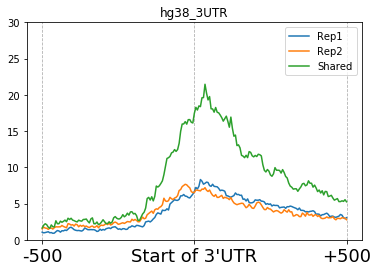

In [93]:
# Region Profile
PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'
INPUT_read_file = PATH_FOLDER+'/'+"Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"


PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'

Gene_Name='hg38_3UTR.bed'

INPUT_gene_list = PATH_FOLDER + Gene_Name
boundary_type='TSS'

resolution = 5
upstreamExtension = 500
num_profile_points= 2*upstreamExtension / resolution +1
window_size = resolution

norm_profile_TSS   = Get_Boundary_Profile(boundary_type, INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
norm_profile2_TSS   = Get_Boundary_Profile(boundary_type, INPUT_read_file2, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
norm_profile3_TSS   = Get_Boundary_Profile(boundary_type, INPUT_read_file3, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
print "...................................................."
print "Profile on: TSS_3'UTR_TES "

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_TSS[0:num_profile_points], label='Rep1')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2_TSS[0:num_profile_points], label='Rep2')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile3_TSS[0:num_profile_points], label='Shared')


ax.set_title(Gene_Name[:-4])
ax.legend()
ax.set_ylim(0,30)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'Start of 3\'UTR','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')
#ax.grid(True)

In [99]:
def profile_Up_genebody_Down_site(upstream_profile, site_body_profile, downstream_profile, upstream_profile2, site_body_profile2, downstream_profile2,upstream_profile3, site_body_profile3, downstream_profile3, resolution, genic_partition,
                                  upstreamExtension, downstreamExtension, genes_set_name, site_name, con_name,con_name2,con_name3):
##########################################################################################    
    upstream_xValues = numpy.arange(0, upstreamExtension + 1, resolution)[-1::-1] * (-1)
#########################################################################################
    downstream_xValues = numpy.arange(0, downstreamExtension + 1, resolution)
##########################################################################################
    site_body_xValues = [0.0] * genic_partition
    for i in xrange(genic_partition):
        site_body_xValues[i] = (i + 0.5) / genic_partition
    ### Plot     
    numTicksInBody = 5

    upstream_scale = 0.5
    upstream_scaled_xValues = [numTicksInBody * upstream_scale * (1 + item * 1.0 / upstreamExtension) for item in
                               upstream_xValues]

    site_body_scaled_xValues = [numTicksInBody * upstream_scale + item * numTicksInBody for item in
                                site_body_xValues]

    downstream_scale = 0.5
    downstream_scaled_xValues = [
        numTicksInBody * upstream_scale + numTicksInBody + numTicksInBody * downstream_scale * item * 1.0 / downstreamExtension
        for item in downstream_xValues]

    xValues = upstream_scaled_xValues + site_body_scaled_xValues + downstream_scaled_xValues
    
    profile = numpy.append(upstream_profile[0:upstreamExtension/resolution+1], site_body_profile)
    profile = numpy.append(profile, downstream_profile[downstreamExtension/resolution:])
    
    profile2 = numpy.append(upstream_profile2[0:upstreamExtension/resolution+1], site_body_profile2)
    profile2 = numpy.append(profile2, downstream_profile2[downstreamExtension/resolution:])
    
    profile3 = numpy.append(upstream_profile3[0:upstreamExtension/resolution+1], site_body_profile3)
    profile3 = numpy.append(profile3, downstream_profile3[downstreamExtension/resolution:])

    xticks_subset = [0] * (numTicksInBody + 1)
    xticklabels_subset = [0] * (numTicksInBody + 1)
    for i in xrange(numTicksInBody + 1):
        xticks_subset[i] = numTicksInBody * upstream_scale + i
        if i == 0:
            xticklabels_subset[i] = 'Start'
        elif i == numTicksInBody:
            xticklabels_subset[i] = 'End'
        else:
            xticklabels_subset[i] = str(i * 1.0 / numTicksInBody)

    xticks = [0] + xticks_subset + [xticks_subset[-1] + numTicksInBody * downstream_scale]
    xticklabels = [ '-'+str(upstreamExtension)] + xticklabels_subset + [
        str(downstreamExtension)]


    fig, ax=plt.subplots(1,1, figsize=(12,6))
    
    ax.plot(xValues, profile, label=con_name)
    ax.plot(xValues, profile2, label=con_name2)
    ax.plot(xValues, profile3, label=con_name3)
    
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_title(genes_set_name, fontsize=16)
    ax.set_xlabel('Site Coordinate', fontsize=12)
    ax.legend()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=14)
    ax.set_ylabel('RPKM', fontsize=24)
    fig_name='Profile-SiteBody-'+genes_set_name+'_'+con_name
    plt.savefig(fig_name + '.png', format='png')

    return None

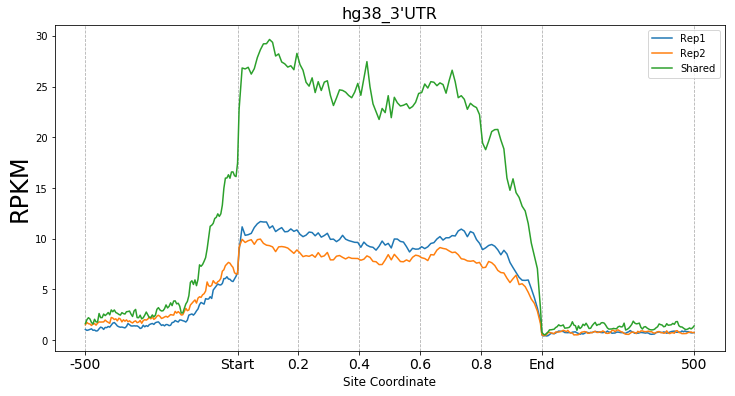

In [101]:
genes_set_name="hg38_3'UTR"
site_name="hg38_3'UTR"
con_name="Rep1"
profile_Up_genebody_Down_site(norm_profile_TSS, norm_profile, norm_profile_TES, norm_profile2_TSS, norm_profile_2, norm_profile2_TES,
                              norm_profile3_TSS, norm_profile_3, norm_profile3_TES, resolution, genic_partition,
                                  upstreamExtension, upstreamExtension, genes_set_name, site_name, con_name, "Rep2","Shared")